In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier

np.random.seed(42)
%matplotlib inline

## 1. Introduction

Random Forest is a Machine Learning algorithm that combines multiple decision trees
to produce a single final output.

Each tree in the forest is trained on a **bootstrap** version of the training dataset,
obtained via **sampling with replacement**, and at each node the split search is restricted to
a random subset of candidate variables.

Repeating this procedure generates a collection of trees trained on slightly different samples
and partially different predictor sets, promoting diversity across models.

The final Random Forest prediction is obtained by aggregating individual tree outputs:
- **Classification**: majority vote.
- **Regression**: average.

Since decision trees are the base learner of this model, we first review how a decision tree works.

## 2. Decision Trees

A decision tree is an algorithm named after its hierarchical structure (tree shape),
consisting of a root node, branches, internal nodes, and leaf nodes.

Its objective is to find the best splits of the data into subsets and, in practice, trees are
typically trained using **CART**.

### 2.1. CART

#### Classification
In classification, the split is chosen by maximizing the improvement in an impurity criterion.  
At node $t$, let $p_k(t)$ be the proportion of class $k$, defined as:
$$
p_k(t) = \frac{1}{n_t} \sum_{x_i \in t} \mathbb{I}(y_i = k)
$$
where $n_t$ is the number of samples in node $t$ and $\mathbb{I}$ is the indicator function.

**Gini impurity**
$$
G(t)=1-\sum_{k=1}^{K} p_k(t)^2
$$
*Intuition*: Gini measures the probability of incorrectly classifying a randomly chosen element from the set if it were randomly labeled according to the distribution of labels in the subset. Lower Gini indicates higher purity.

**Entropy**
$$
H(t)=-\sum_{k=1}^{K} p_k(t)\log p_k(t)
$$

A split $s$ divides node $t$ into $t_L, t_R$. The improvement is:
$$
\Delta I(s,t)=I(t)-\frac{n_L}{n}I(t_L)-\frac{n_R}{n}I(t_R)
$$
where $I(\cdot)$ can be $G$ or $H$. Gini $G(t)$ is commonly used in CART. Entropy $H(t)$ is common in information-theoretic splits.

Maximizing this criterion is equivalent to minimizing the weighted impurity of the child nodes on average, so leaves give clearer majority-class predictions and classification error typically decreases.

**Optimization (Finding $s$):**
The split $s$ is selected by performing an exhaustive greedy search. The algorithm iterates through every feature and every possible threshold (sorted values) to find the specific pair that maximizes $\Delta I(s,t)$.

#### Regression
In regression, each leaf predicts the average of $y$ in that leaf:
$$
\hat{y}(t)=\bar{y}_t=\frac{1}{n_t}\sum_{i\in t} y_i
$$

Splits are chosen by minimizing within-node squared error:
$$
\sum_{i\in L}(y_i-\bar{y}_L)^2 + \sum_{i\in R}(y_i-\bar{y}_R)^2
$$

**Optimization:**
Unlike methods that rely on Gradient Descent, decision trees minimize this error through a greedy search over candidate splits. For each feature, the samples in the node are sorted and thresholds (typically midpoints between consecutive unique values) are evaluated. For every candidate split, the within-node squared error of the two child nodes is computed in closed form (each child predicts its sample mean), and the split that yields the smallest total squared error is selected.

Decision trees can model complex non-linear rules, but they are unstable (high variance):
small changes in the dataset can lead to a very different tree, and deep trees may overfit.

#### Simulation: Best split using Gini 

We illustrate the core CART idea in classification: find the threshold $\theta$ that maximizes the reduction in impurity (Gini).


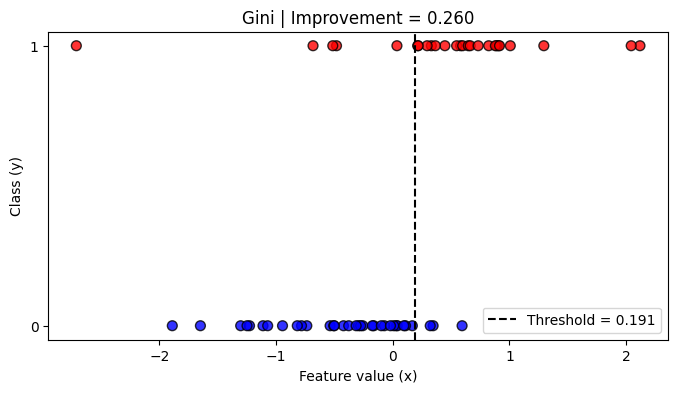

In [ ]:
def gini(y):
    if len(y) == 0:
        return 0
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

def best_split(x, y):
    idx = np.argsort(x)
    x_sort = x[idx]
    y_sort = y[idx]
    
    base_gini = gini(y_sort)
    best_gain = 0
    best_t = 0
    
    for i in range(1, len(x_sort)):
        if x_sort[i] == x_sort[i - 1]: continue
        
        # threshold
        t = (x_sort[i] + x_sort[i-1]) / 2
        
        # split data
        left = y_sort[x_sort <= t]
        right = y_sort[x_sort > t]
        
        # improvement
        w_left = len(left) / len(y_sort)
        w_right = len(right) / len(y_sort)
        gain = base_gini - (w_left * gini(left)) - (w_right * gini(right))
        
        if gain > best_gain:
            best_gain = gain
            best_t = t
            
    return best_t, best_gain

# Create simple data
rng = np.random.default_rng(1)
x = rng.normal(size = 60)
y = (x > 0.2).astype(int)

# add some noise
noise_idx = rng.choice(len(y), size = 8, replace=False)
y[noise_idx] = 1 - y[noise_idx] 

thr, gain = best_split(x, y)

plt.figure(figsize = (8, 4))
plt.scatter(x, y, c= y, cmap = 'bwr', edgecolor = 'k', s = 50, alpha = 0.8)
plt.axvline(thr, color = 'k', linestyle = "--", label =f"Threshold = {thr:.3f}")
plt.yticks([0, 1])
plt.xlabel("Feature value (x)")
plt.ylabel("Class (y)")
plt.title(f"Gini | Improvement = {gain:.3f}")
plt.legend()
plt.show()

# Some parts of this code were generated with ChatGPT and then reviewed/modified by me.



## 3. Bagging

One way to address the high variance of a single decision tree is to combine many trees.
Averaging multiple models reduces variance.


### 3.1. Bootstrap

Given a dataset with $n$ rows, we build a new dataset of size $n$ by sampling with replacement.

A row can: appear multiple times or not appear at all.


### 3.2. Model Ensembling (Reducing Variance)

Repeat $B$ times:
1) Draw a bootstrap sample.
2) Train a decision tree on that bootstrap sample.

Then aggregate predictions:
- regression: average,
- classification: majority vote.

Averaging works best when models are not too correlated.

If each tree has variance $\sigma^2$ and average correlation $\rho$, the variance of the average is:
$$
\mathrm{Var}\left(\frac{1}{B}\sum_{b=1}^{B}h_b(x)\right)=\rho\sigma^2+\frac{(1-\rho)\sigma^2}{B}
$$

As $B\to\infty$, the term $\frac{(1-\rho)\sigma^2}{B}\to 0$ and we get $\rho\sigma^2$.
Conclusion: even with many trees, if trees are strongly correlated (high $\rho$), improvement is limited.


#### Simulation: Bagging reduces variance

We illustrate how Bagging reduces variance in these two graphics

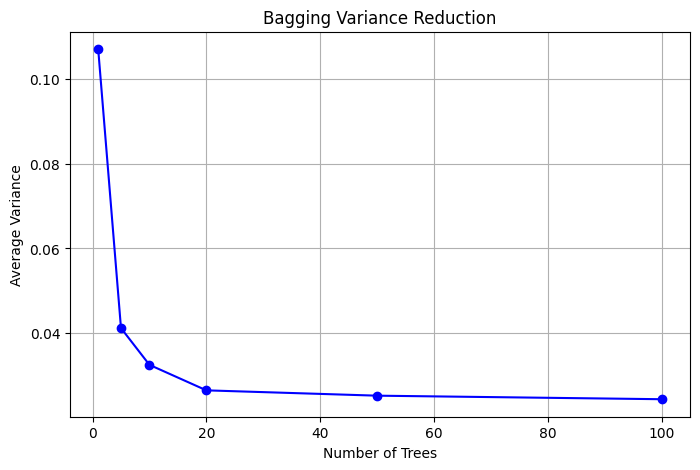

In [ ]:
def check_variance():
    # settings
    n_train = 100
    n_reps = 30
    
    # Fixed test set
    x_test, _ = make_moons(n_samples = 50, noise = 0.35, random_state = 42)
    
    n_trees = [1, 5, 10, 20, 50, 100]
    results = []
    
    for b in n_trees:
        preds = []
        for i in range(n_reps):
            # get random training data
            x_train, y_train = make_moons(n_samples=n_train, noise = 0.35)
            
            # train model
            model = BaggingClassifier(n_estimators = b)
            model.fit(x_train, y_train)
            
            # predict
            p = model.predict_proba(x_test)[:, 1]
            preds.append(p)
            
        # calculate variance
        preds = np.array(preds)
        var = np.var(preds, axis = 0)
        results.append(np.mean(var))
        
    # Plot results
    plt.figure(figsize = (8, 5))
    plt.plot(n_trees, results, '-o',color ='blue')
    plt.xlabel("Number of Trees")
    plt.ylabel("Average Variance")
    plt.title("Bagging Variance Reduction")
    plt.grid(True)
    plt.show()

check_variance()

# Some parts of this code were generated with ChatGPT and then reviewed/modified by me.

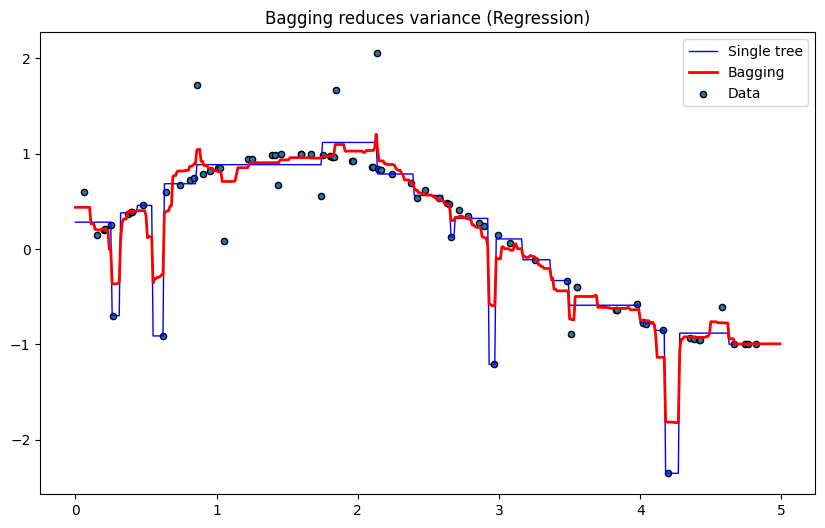

In [ ]:
X = np.sort(5 * np.random.rand(80, 1), axis = 0)
y = np.sin(X).ravel()

# add some outliers
y[::5] += 3 * (0.5 - np.random.rand(16))

tree = DecisionTreeRegressor(max_depth = 5, random_state = 42)
tree.fit(X, y)

bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth = 5),
    n_estimators = 50,
    random_state = 42
)
bag.fit(X, y)

X_grid = np.arange(0.0, 5.0, 0.01)[:, None]
y_tree = tree.predict(X_grid)
y_bag = bag.predict(X_grid)

plt.figure(figsize = (10, 6))
plt.plot(X_grid, y_tree,  color ="blue", linewidth = 1, label = "Single tree")
plt.plot(X_grid, y_bag,  color="red", linewidth = 2, label = "Bagging")
plt.scatter(X, y, s = 20, edgecolor ="black", label = "Data")
plt.title("Bagging reduces variance (Regression)")
plt.legend()
plt.show()

# Some parts of this code were generated with ChatGPT and then reviewed/modified by me.

## 4. Random Forest

Random Forest adds one more improvement to bagging: random subspace.


### 4.1. Random subspace

Random subspace means using random features at each split.

In a standard tree, at each node we could evaluate all features to pick the best split.
In Random Forest, at each split the tree only considers a random subset of features of size $m$
(parameter `max_features`).

This reduces similarity between trees, decreases correlation $\rho$, and therefore reduces the variance of the averaged predictor.


#### Simulation: Test error vs m

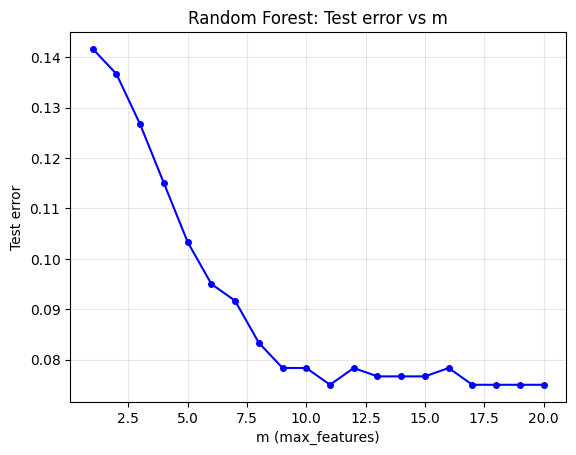

In [ ]:
X, y = make_moons(n_samples = 2000, noise = 0.25, random_state = 0)

# Add extra random noise features
rng = np.random.RandomState(0)
X = np.hstack([X, rng.normal(size = (X.shape[0], 18))])

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size = 0.3, random_state = 0, stratify = y
)

p = X_tr.shape[1]
m_values = np.arange(1, p + 1)

err = []
for m in m_values:
    rf = RandomForestClassifier(
        n_estimators = 300,
        max_features =m,
        random_state = 0,
        n_jobs = -1
    )
    rf.fit(X_tr, y_tr)
    err.append(1 - rf.score(X_te, y_te))

plt.figure()
plt.plot(m_values, err,color = 'blue', marker = "o", markersize = 4)
plt.xlabel("m (max_features)")
plt.ylabel("Test error")
plt.title("Random Forest: Test error vs m")
plt.grid(True, alpha = 0.3)
plt.show()

# Some parts of this code were generated with ChatGPT and then reviewed/modified by me.

### 4.2. Algorithm step by step

Given a dataset $\{(x_i, y_i)\}_{i=1}^{n}$, choose:
- $B$: number of trees (`n_estimators`)
- $m$: number of candidate features per split (`max_features`)

For $b=1,\dots,B$:
1. Bootstrap: sample $n$ examples with replacement -> indices $I_b$
2. Train a CART tree where at each node:
   - randomly select $m$ features
   - search the best split only among those $m$
3. Store the tree $h_b$


### 4.3. Prediction

Classification (majority vote):
$$
\hat{y}(x)=\arg\max_{k\in\{1,\dots,K\}}\sum_{b=1}^{B}\mathbf{1}\{h_b(x)=k\}
$$

Regression (average):
$$
\hat{y}(x)=\frac{1}{B}\sum_{b=1}^{B} h_b(x)
$$


#### Simulation: Single Tree vs Bagging vs Random Forest
For this simulation we are going to use the dataset 'make_moons' available at sklearn.datasets
We compare:
- Single Tree.
- Bagging.
- Random Forest.

Idea: bagging reduces variance by averaging, and Random Forest improves further by lowering tree correlation $\rho$.


In [ ]:
# Dataset for visualization
X, y = make_moons(n_samples = 800, noise = 0.25, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Single tree
tree = DecisionTreeClassifier(random_state = 0)
tree.fit(X_train, y_train)
tree_err = 1 - tree.score(X_test, y_test)

# Bagging
bag = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state = 0),
    n_estimators = 150,
    bootstrap =True,
    random_state = 0
)
bag.fit(X_train, y_train)
bag_err  = 1 - bag.score(X_test, y_test)

# Random Forest
rf = RandomForestClassifier(
    n_estimators = 150,
    max_features = "sqrt",
    bootstrap = True,
    random_state = 0
)
rf.fit(X_train, y_train)
rf_err   = 1 - rf.score(X_test, y_test)

# Some parts of this code were generated with ChatGPT and then reviewed/modified by me.

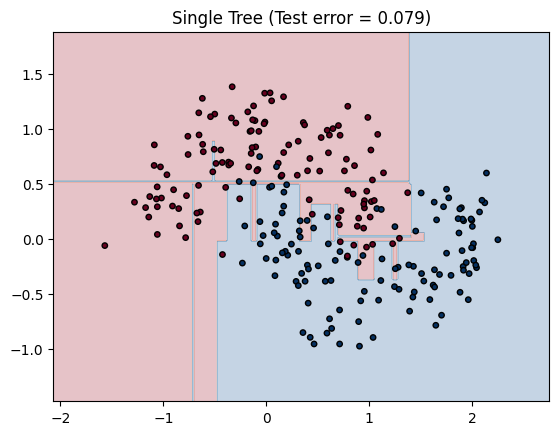

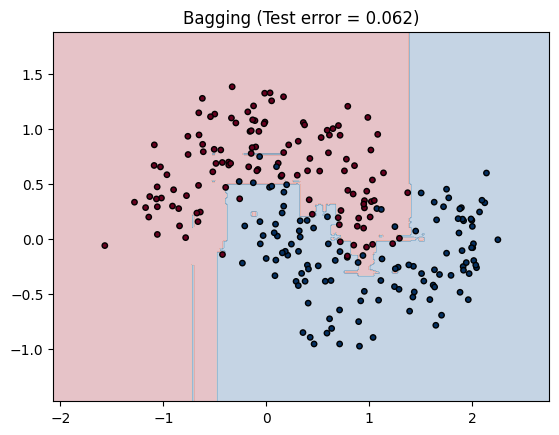

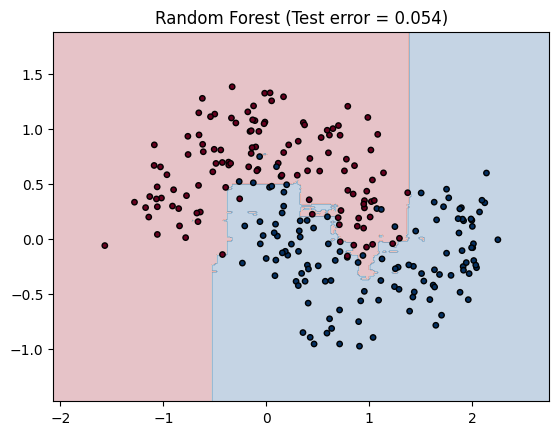

In [7]:
def plot_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha = 0.25, cmap = 'RdBu')
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 15, cmap = 'RdBu', edgecolor = 'k')
    plt.title(title)
    plt.show()

plot_boundary(tree, X_test, y_test, f"Single Tree (Test error = {tree_err:.3f})")
plot_boundary(bag,  X_test, y_test, f"Bagging (Test error = {bag_err:.3f})")
plot_boundary(rf,   X_test, y_test, f"Random Forest (Test error = {rf_err:.3f})")


## 5. OOB (Out-of-Bag)

OOB exists because Random Forest trains each tree using bootstrap samples.
When sampling with replacement, some observations appear multiple times and others are not selected at all.

Probability that a specific observation is not selected in one draw:
$$
1-\frac{1}{n}
$$

Probability it is not selected in $n$ draws:
$$
\left(1-\frac{1}{n}\right)^n \approx e^{-1}\approx 0.368
$$

Therefore, about 36.8% of observations are OOB for a given tree.

To estimate OOB error:
- for each observation, predict using only trees for which that observation was OOB,
- aggregate votes (or averages),
- compute a global error.

This provides a test-like error estimate without holding out a separate validation set.


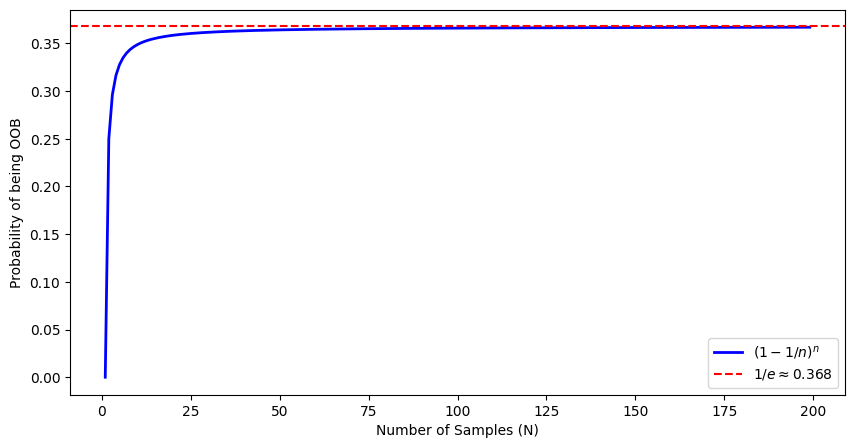

In [8]:
def simulate_oob_probability(max_n = 200):
    n_values = np.arange(1, max_n)
    exact_values = (1 - 1/n_values) ** n_values
    
    plt.figure(figsize = (10, 5))
    plt.plot(n_values, exact_values, label = r'$(1 - 1/n)^n$', linewidth = 2, color = 'blue')
    plt.axhline(y = 1/np.e, color = 'r', linestyle = '--', label = r'$1/e \approx 0.368$')
    
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Probability of being OOB')
    plt.legend()
    plt.show()
    
simulate_oob_probability()

## Authors

**Author:** Gonzalo Ruiz Moreno 

**Course:** Machine Learning  

**Degree:** ADEINF 

**University:** CUNEF

**Year:** 2026